In [1]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
from pymc.math import switch, gt, lt, dot
import seaborn as sns
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')

In [2]:
pm.__version__

'4.2.2'

In [3]:
np.__version__

'1.19.2'

# Linear Regression

In [4]:
data = pd.read_csv("store_spend.csv").drop('Unnamed: 0', axis = 1, inplace=False)
data

,avg_spend,first_time,times_visited_this_week,view_time,spend
0,3.59,0,1,0.681891,87.54
1,3.70,0,2,0.696954,165.24
2,0.00,1,0,1.713135,17.66
3,0.00,0,0,0.194384,22.08
4,15.62,0,2,0.742095,243.99
...,...,...,...,...,...
995,13.86,0,2,0.977816,213.67
996,11.40,0,2,0.168461,19.76
997,0.00,0,0,0.114228,32.07
998,7.28,0,1,0.279810,10.89


In [5]:
with pm.Model() as m:
    
    # associate data with model (this makes prediction easier)
    avg_spend = pm.Data("avg_spend", data['avg_spend'], mutable=True)
    first_time = pm.Data("first_time", data['first_time'], mutable=True)
    times_visited_this_week = pm.Data("times_visited_this_week", data['times_visited_this_week'], mutable=True)
    view_time = pm.Data("view_time", data['view_time'], mutable=True)

    spend = pm.Data("spend", data['spend'], mutable=False)
    
    # priors
    b0 = pm.Normal("b0_intercept", mu=0, sigma=1000)
    b1 = pm.Normal("b1_avg_spend", mu=0, sigma=1000)
    b2 = pm.Normal("b2_first_time", mu=0, sigma=1000)
    b3 = pm.Normal("b3_times_visited_this_week", mu=0, sigma=1000)
    b4 = pm.Normal("b4_view_time", mu=0, sigma=1000)
    
    # interaction priors
    b5 = pm.Normal("b5_avg_spend_*_view_time", mu=0, sigma=1000)
    b6 = pm.Normal("b6_times_visited_this_week_*_view_time", mu=0, sigma=1000)
    b7 = pm.Normal("b7_times_visited_this_week_*_avg_spend", mu=0, sigma=1000)


    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = 1 / pm.math.sqrt(tau)


    mu = b0 + (b1 * avg_spend) + (b2 * first_time) + (b3 * times_visited_this_week) + (b4 * view_time) + \
              (b5 * (avg_spend * view_time)) + (b6 * (times_visited_this_week * view_time)) + (b7 * (times_visited_this_week * avg_spend))
    
    # likelihood
    likelihood = pm.Normal("spend_likelihood", mu=mu, sigma=sigma, observed=spend)
    
    
    # start sampling
    trace = pm.sample(
        10000,  # samples
        chains=4,
        tune=1000,
        init="jitter+adapt_diag",
        random_seed=1,
        cores=4,
        return_inferencedata=True,
        target_accept=0.95,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0_intercept, b1_avg_spend, b2_first_time, b3_times_visited_this_week, b4_view_time, b5_avg_spend_*_view_time, b6_times_visited_this_week_*_view_time, b7_times_visited_this_week_*_avg_spend, tau]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 76 seconds.


In [6]:
az.summary(trace, hdi_prob=0.95,  var_names='b', filter_vars="like", kind = 'stats')

,mean,sd,hdi_2.5%,hdi_97.5%
b0_intercept,35.368,4.527,26.504,44.198
b1_avg_spend,-0.835,0.655,-2.102,0.462
b2_first_time,4.230,6.053,-7.631,16.092
b3_times_visited_this_week,37.223,3.102,31.325,43.483
b4_view_time,22.832,4.475,14.371,31.777
b5_avg_spend_*_view_time,0.620,0.544,-0.441,1.692
b6_times_visited_this_week_*_view_time,-8.304,2.821,-13.663,-2.600
b7_times_visited_this_week_*_avg_spend,0.929,0.308,0.326,1.536


In [8]:
# get the mean y_pred across all chains
ppc = pm.sample_posterior_predictive(trace, model=m)
y_pred = ppc.posterior_predictive.stack(sample=("chain", "draw"))["spend_likelihood"].values.mean(axis=1)
az.r2_score(data['spend'], y_pred)

r2        0.41661
r2_std    0.00000
dtype: float64

In [9]:
pd.DataFrame(az.summary(ppc, hdi_prob=0.95, kind='stats').mean(axis=0)).T

,mean,sd,hdi_2.5%,hdi_97.5%
0,95.491074,55.903922,-13.920241,204.96134


In [10]:
# prediction

pm.set_data({'avg_spend':np.array([30.0]),
            'first_time':np.array([0]),
            'times_visited_this_week':np.array([2]),
            'view_time':np.array([2.0])}, 
            model=m)

ppc = pm.sample_posterior_predictive(trace, model=m)

In [13]:
y = 35.368 + (-0.835 * 30) + (4.230	 * 0) + (37.223 * 2) + (22.832	 * 2) + (0.620 * 30 * 2) + (-8.304 * 2 * 2) + (0.929 * 30 * 2 )
y

190.152

In [12]:
pd.DataFrame(az.summary(ppc, hdi_prob=0.95, kind='stats').mean(axis=0)).T

,mean,sd,hdi_2.5%,hdi_97.5%
0,190.198151,58.596309,75.431651,304.867301


array([[<AxesSubplot:title={'center':'b0_intercept'}>,
        <AxesSubplot:title={'center':'b1_avg_spend'}>,
        <AxesSubplot:title={'center':'b2_first_time'}>,
        <AxesSubplot:title={'center':'b3_times_visited_this_week'}>],
       [<AxesSubplot:title={'center':'b4_view_time'}>,
        <AxesSubplot:title={'center':'b5_avg_spend_*_view_time'}>,
        <AxesSubplot:title={'center':'b6_times_visited_this_week_*_view_time'}>,
        <AxesSubplot:title={'center':'b7_times_visited_this_week_*_avg_spend'}>]],
      dtype=object)

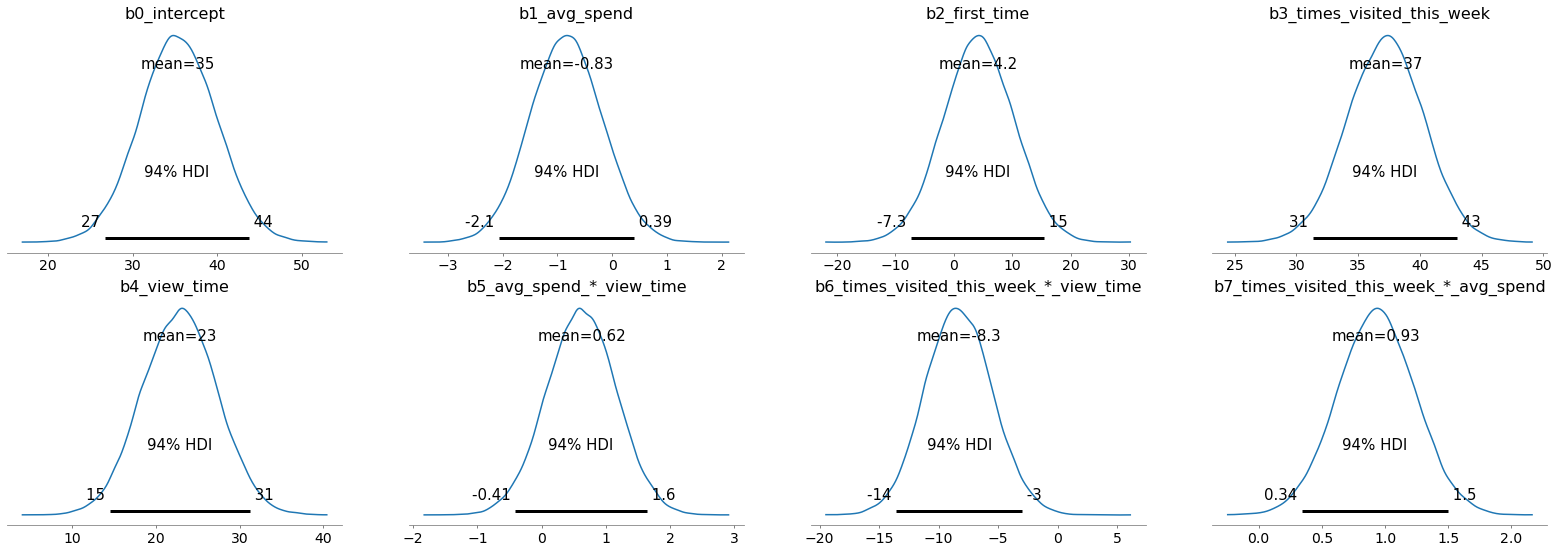

In [14]:
az.plot_posterior(trace, var_names='b', filter_vars="like")

array([[<AxesSubplot:title={'center':'b0_intercept'}>,
        <AxesSubplot:title={'center':'b0_intercept'}>],
       [<AxesSubplot:title={'center':'b1_avg_spend'}>,
        <AxesSubplot:title={'center':'b1_avg_spend'}>],
       [<AxesSubplot:title={'center':'b2_first_time'}>,
        <AxesSubplot:title={'center':'b2_first_time'}>],
       [<AxesSubplot:title={'center':'b3_times_visited_this_week'}>,
        <AxesSubplot:title={'center':'b3_times_visited_this_week'}>],
       [<AxesSubplot:title={'center':'b4_view_time'}>,
        <AxesSubplot:title={'center':'b4_view_time'}>],
       [<AxesSubplot:title={'center':'b5_avg_spend_*_view_time'}>,
        <AxesSubplot:title={'center':'b5_avg_spend_*_view_time'}>],
       [<AxesSubplot:title={'center':'b6_times_visited_this_week_*_view_time'}>,
        <AxesSubplot:title={'center':'b6_times_visited_this_week_*_view_time'}>],
       [<AxesSubplot:title={'center':'b7_times_visited_this_week_*_avg_spend'}>,
        <AxesSubplot:title={'center'

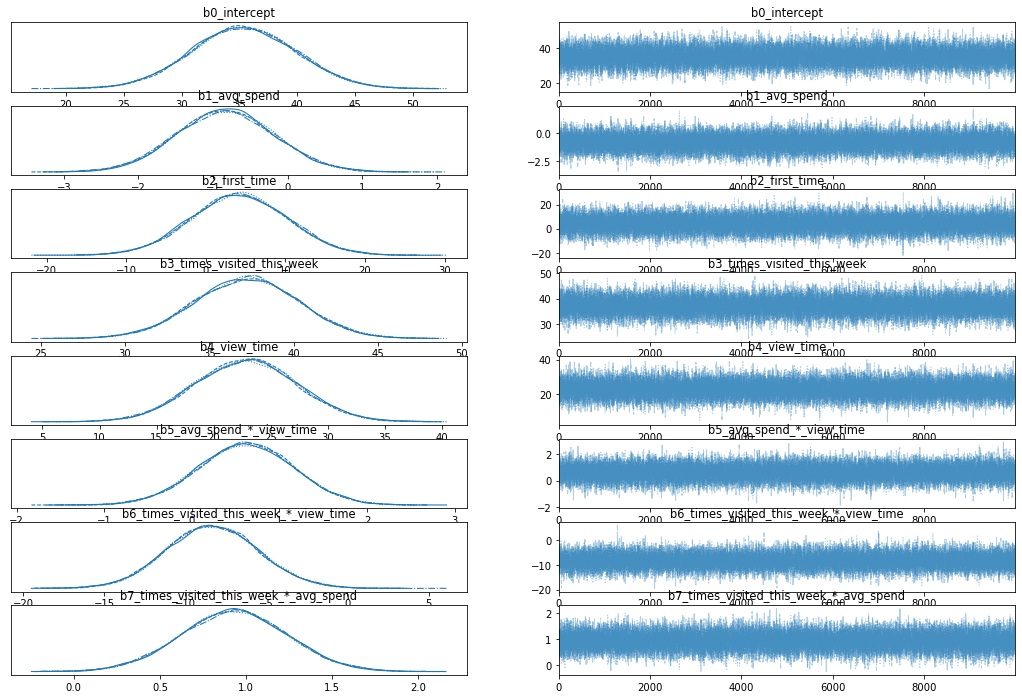

In [15]:
az.plot_trace(trace, var_names='b', filter_vars="like", figsize=(18, 12))

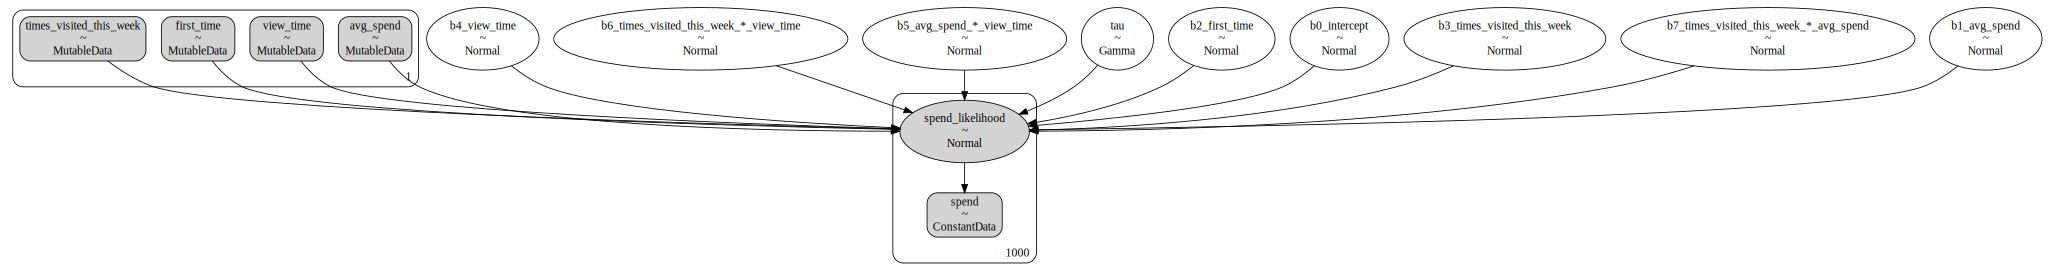

In [16]:
pm.model_to_graphviz(m)

# Logistic Regression

In [17]:
data = pd.read_csv("melanoma_length.csv").drop('Unnamed: 0', axis = 1, inplace=False)
data

,LENGTH,SURVIVED,DIED,TOTAL
0,8.375,6,6,12
1,5.975,45,31,76
2,5.900,20,6,26
3,3.650,26,20,46
4,7.775,11,29,40
...,...,...,...,...
995,6.950,7,7,14
996,4.475,19,16,35
997,8.750,1,29,30
998,5.600,15,1,16


In [18]:
data.describe()

,LENGTH,SURVIVED,DIED,TOTAL
count,1000.00000,1000.000000,1000.000000,1000.000000
mean,6.14630,34.108000,15.037000,49.145000
std,2.06559,23.916026,14.926769,27.831755
min,1.25000,1.000000,0.000000,1.000000
25%,4.77500,11.000000,2.000000,25.000000
50%,6.65000,32.000000,10.000000,50.000000
75%,7.85000,58.000000,26.000000,69.000000
max,8.75000,71.000000,49.000000,117.000000


In [19]:
with pm.Model() as m:
    
    x_data = pm.Data("length", data['LENGTH'], mutable=True)
    s_data = pm.Data("survived", data['SURVIVED'], mutable=False)
    n_data = pm.Data("total", data['TOTAL'], mutable=False)
    
    b0 = pm.Normal("b0_intercept", mu=0, sigma=1000)
    b1 = pm.Normal("b1_length", mu=0, sigma=1000)
    
    p = pm.math.invlogit(b0 + (b1 * x_data))
    
    # likelihood
    likelihood = pm.Binomial("likelihood", n=n_data, p=p, observed=s_data)    
    
    trace = pm.sample(
        10000,  # samples
        chains=4,
        tune=1000,
        init="jitter+adapt_diag",
        random_seed=1,
        cores=4,
        return_inferencedata=True,
        target_accept=0.95,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0_intercept, b1_length]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.


In [20]:
summary = az.summary(trace, hdi_prob=0.95, var_names='b', filter_vars = 'like', kind='stats')
summary


,mean,sd,hdi_2.5%,hdi_97.5%
b0_intercept,3.707,0.041,3.625,3.787
b1_length,-0.468,0.006,-0.481,-0.457


In [21]:
expit(summary.loc['b0_intercept','mean'] + (summary.loc['b1_length','mean'] * 2.75))

0.9183397445384054

In [22]:
az.waic(trace, scale="deviance")

Computed from 40000 posterior samples and 1000 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 13025.03   400.82
p_waic           24.46        -

There has been a warning during the calculation. Please check the results.

array([<AxesSubplot:title={'center':'b0_intercept'}>,
       <AxesSubplot:title={'center':'b1_length'}>], dtype=object)

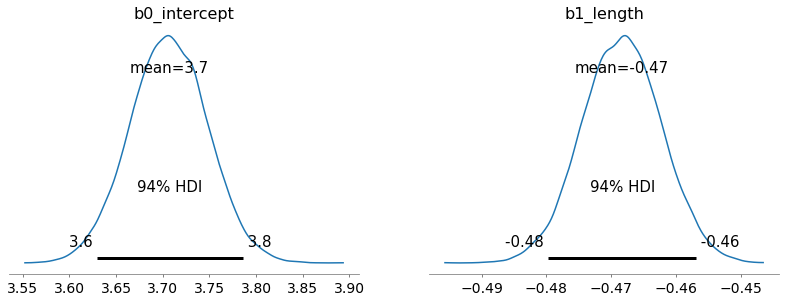

In [23]:
az.plot_posterior(trace, var_names='b', filter_vars = 'like')

array([[<AxesSubplot:title={'center':'b0_intercept'}>,
        <AxesSubplot:title={'center':'b0_intercept'}>],
       [<AxesSubplot:title={'center':'b1_length'}>,
        <AxesSubplot:title={'center':'b1_length'}>]], dtype=object)

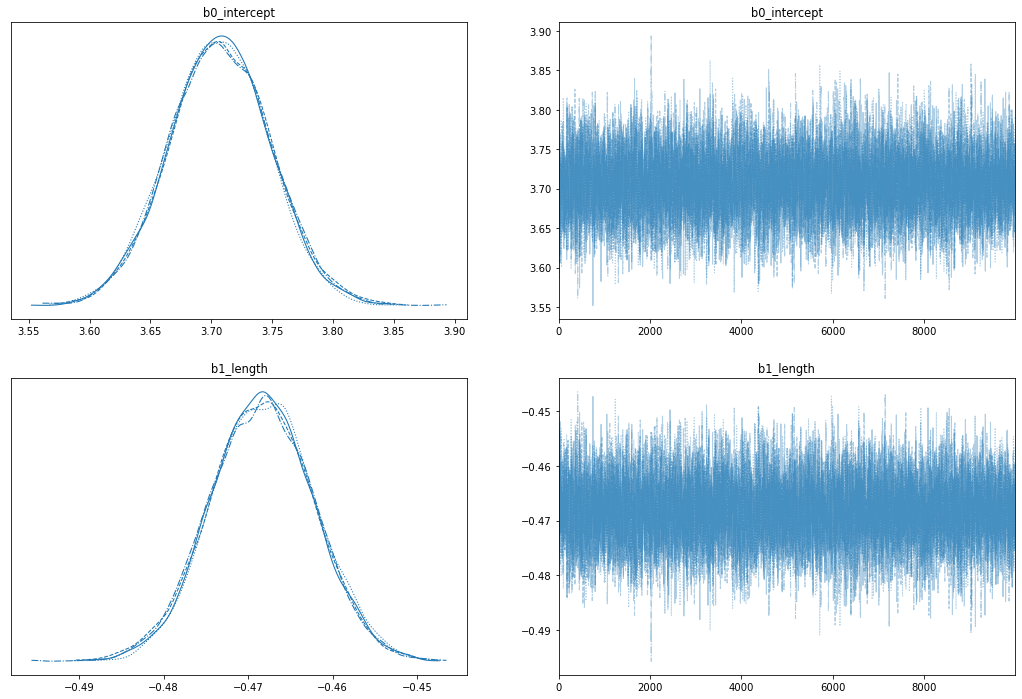

In [24]:
az.plot_trace(trace, var_names='b', filter_vars = 'like', figsize=(18, 12))

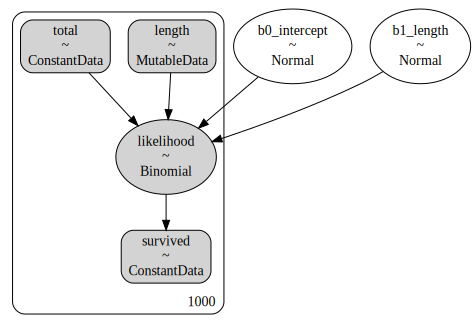

In [25]:
pm.model_to_graphviz(m)

# Poisson Regression

In [26]:
data = pd.read_csv("water_cancer.csv").drop('Unnamed: 0', axis = 1, inplace=False)
data

,chlorine,radium,num_cancer
0,2.818,7.751,23
1,1.764,4.488,30
2,2.321,4.369,24
3,2.610,2.882,28
4,2.930,6.010,29
...,...,...,...
995,3.144,5.081,24
996,2.730,3.307,27
997,3.824,11.919,26
998,2.386,4.237,20


In [27]:
with pm.Model() as m:
    
    chlorine = pm.Data("chlorine", data['chlorine'], mutable=True)
    radium = pm.Data("radium", data['radium'], mutable=True)
    num_cancer = pm.Data("num_cancer", data['num_cancer'], mutable=False)

    # define priors, uninformative Normal
    b0 = pm.Normal("b_intercept", mu=0, sigma=1000)
    b1 = pm.Normal("b_chlorine", mu=0, sigma=1000)
    b2 = pm.Normal("b_radium", mu=0, sigma=1000)


    # define linear model and exp link function
    mu = pm.math.exp(b0 + (b1 * chlorine) + (b2 * radium)) 

    ## Define Poisson likelihood
    likelihood = pm.Poisson("likelihood", mu=mu, observed=num_cancer)
    
    trace = pm.sample(
        10000,  # samples
        chains=4,
        tune=1000,
        init="jitter+adapt_diag",
        random_seed=42,
        cores=4,
        return_inferencedata=True,
        target_accept=0.95,
    )
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_intercept, b_chlorine, b_radium]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.


In [28]:
az.summary(trace, hdi_prob=0.95, kind = 'stats')

,mean,sd,hdi_2.5%,hdi_97.5%
b_intercept,3.150,0.019,3.114,3.189
b_chlorine,-0.020,0.006,-0.032,-0.008
b_radium,0.024,0.004,0.017,0.031


In [29]:
# prediction
pm.set_data({"chlorine": np.array([3.42]), 
             "radium": np.array([8.16])}, 
             model=m)

ppc = pm.sample_posterior_predictive(trace, model=m)

In [30]:
pd.DataFrame(az.summary(ppc, hdi_prob=0.95, kind='stats').mean(axis=0)).T

,mean,sd,hdi_2.5%,hdi_97.5%
0,26.486279,5.156029,16.068,35.947


array([<AxesSubplot:title={'center':'b_chlorine'}>,
       <AxesSubplot:title={'center':'b_radium'}>], dtype=object)

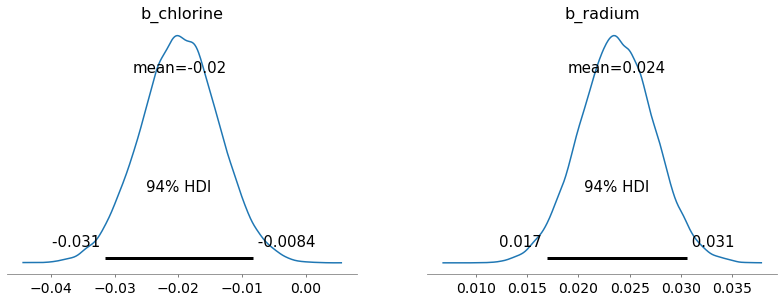

In [31]:
az.plot_posterior(trace, var_names=['b_chlorine', 'b_radium'])

array([[<AxesSubplot:title={'center':'b_intercept'}>,
        <AxesSubplot:title={'center':'b_intercept'}>],
       [<AxesSubplot:title={'center':'b_chlorine'}>,
        <AxesSubplot:title={'center':'b_chlorine'}>],
       [<AxesSubplot:title={'center':'b_radium'}>,
        <AxesSubplot:title={'center':'b_radium'}>]], dtype=object)

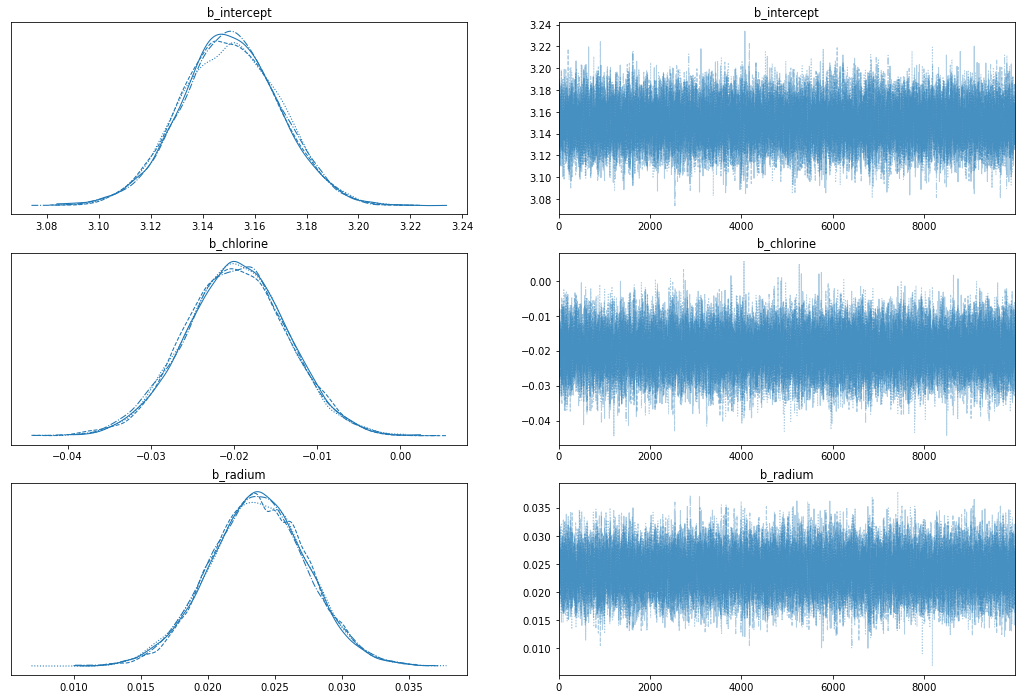

In [32]:
az.plot_trace(trace, figsize=(18, 12))

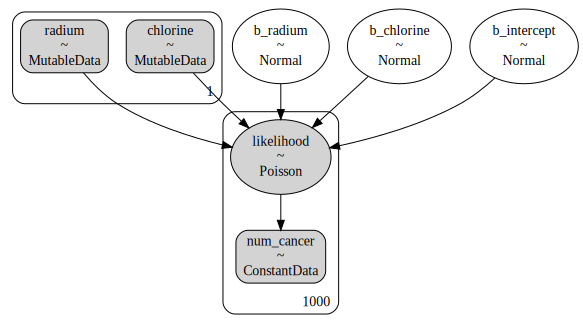

In [33]:
pm.model_to_graphviz(m)